In [ ]:
Moduł ładujący dane.

In [2]:
from scipy import io as io
import numpy as np


def faces_yale_loader():
    data = io.loadmat('data/facesYale.mat')
    y_train = data['personTrain'].flatten()
    y_test = data['personTest'].flatten()
    x_train = data['featuresTrain']
    x_test = data['featuresTest']
    return x_train, x_test, y_train, y_test


def spambase_loader():
    data = io.loadmat('data/spambase.mat')
    y_train = data['classesTrain'].flatten()
    y_test = data['classesTest'].flatten()
    x_train = data['featuresTrain']
    x_test = data['featuresTest']
    return x_train, x_test, y_train, y_test


def spambase_for_cross_validation_loader():
    x_train, x_test, y_train, y_test = spambase_loader()
    return np.vstack((x_train, x_test)), np.concatenate((y_train, y_test))


def hypercubes_loader():
    data = io.loadmat('data/multiDimHypercubes.mat')
    y_train = data['classesTrain'][0]
    y_test = data['classesTest'][0]
    x_train = data['featuresTrain'][0]
    x_test = data['featuresTest'][0]
    return x_train, x_test, y_train, y_test


Moduł obliczający odległość euklidesową oraz wartość błędu dla podych zestawów treningowych i testowych.

In [ ]:
import numpy as np


def euclidean_distance(instance1, instance2):
    return np.linalg.norm(instance2-instance1)


def count_accuracy(x_train, x_test, y_train, y_test, contrary=False):
    incorrect = 0.0
    closest_dist = 0.0
    contrary_dist = 0.0

    for x, y in zip(x_test, y_test):
        dist = euclidean_distance(x, x_train[0])
        contrary_class_dist = dist
        res = y_train[0]
        for x_t, y_t in zip(x_train, y_train):
            e_dist = euclidean_distance(x, x_t)
            if e_dist < dist:
                dist = e_dist
                res = y_t
            if e_dist > contrary_class_dist:
                contrary_class_dist = e_dist
        if y != res:
            incorrect += 1.0
        if contrary:
            closest_dist += dist
            contrary_dist += contrary_class_dist

    if contrary:
        return closest_dist / len(y_test), contrary_dist / len(y_test)
    return incorrect / len(y_test)


Moduł obliczający wartość błędu dla zbioru danych faces.

In [6]:
import data_loader
import accuracy_counter as acc


def main():
    x_train, x_test, y_train, y_test = data_loader.faces_yale_loader()
    print(str(acc.count_accuracy(x_train, x_test, y_train, y_test)))


if __name__ == '__main__':
    main()

0.06666666666666667


Wynik: 0.0666666666667

Moduł obliczający wartość błędu dla z bioru danych spambase, gdzie 10-ta cecha każdego elementu jest przeskalowana przez zmiennąną należącą do przedziału 0-20.

In [2]:
import data_loader
import accuracy_counter as acc


def main():
    x_train_orig, x_test_orig, y_train, y_test = data_loader.spambase_loader()

    for alfa in range(1, 21):
        x_train, x_test = scale(x_train_orig, x_test_orig, alfa)
        print(str(alfa) + ": " + str(acc.count_accuracy(x_train, x_test, y_train, y_test)))


def scale(data_train, data_test, alfa):
    data_train_copy = data_train.copy()
    data_test_copy = data_test.copy()
    data_train_copy[:, -1] *= alfa
    data_test_copy[:, -1] *= alfa

    return data_train_copy, data_test_copy


if __name__ == '__main__':
    main()


1: 0.1790502158600318
2: 0.17450579413769599
3: 0.17791411042944785
4: 0.18132242672119972
5: 0.18291297432401726
6: 0.18586684844353557
7: 0.18859350147693707
8: 0.18836628039082026
9: 0.18972960690752103
10: 0.19063849125198817
11: 0.19177459668257213
12: 0.1929107021131561
13: 0.1929107021131561
14: 0.19154737559645535
15: 0.19427402862985685
16: 0.19450124971597363
17: 0.19518291297432402
18: 0.19359236537150648
19: 0.19222903885480572
20: 0.1931379231992729


Wyniki: 
1: 0.17905021586
2: 0.174505794138
3: 0.177914110429
4: 0.181322426721
5: 0.182912974324
6: 0.185866848444
7: 0.188593501477
8: 0.188366280391
9: 0.189729606908
10: 0.190638491252
11: 0.191774596683
12: 0.192910702113
13: 0.192910702113
14: 0.191547375596
15: 0.19427402863
16: 0.194501249716
17: 0.195182912974
18: 0.193592365372
19: 0.192229038855
20: 0.193137923199

Można zaobserwować, że im mniejsze przeskalowanie, tym błąd klasyfikacji mniejszy.

In [ ]:
Moduł liczący średni błąd przy cross-validation z parametrem fold = 5.

In [3]:
import data_loader
import numpy as np
import accuracy_counter as acc


def main():
    x_set, y_set = data_loader.spambase_for_cross_validation_loader()
    folds_number = 5

    for i in range(10):
        x_folds, y_folds = get_data(x_set, y_set, folds_number=folds_number)

        error_rates = []
        for k in range(folds_number):
            x_test = x_folds[k]
            y_test = y_folds[k]

            x_train = np.vstack(x_fold for i, x_fold
                                in enumerate(x_folds)
                                if i != k)

            y_train = np.concatenate([y_fold for i, y_fold
                                      in enumerate(y_folds)
                                      if i != k])

            error_rates.append(acc.count_accuracy(x_train, x_test, y_train, y_test))
        print(np.array(error_rates).mean())


def get_data(x_set, y_set, folds_number=3):
    random_permutation = np.random.permutation(len(x_set))

    shuffled_x = x_set[random_permutation]
    shuffled_y = y_set[random_permutation]

    x_folds = np.array_split(shuffled_x, folds_number)
    y_folds = np.array_split(shuffled_y, folds_number)

    return x_folds, y_folds


if __name__ == '__main__':
    main()

0.0828090921966
0.0888946324883
0.0880271916159
0.0862868809895
0.088458669688
0.0891103715243
0.0912838124911
0.0873731293962
0.0851980361611
0.0873743095879


Moduł tworzący wykres pokazujący jak zmienia się wartość błędu w stosunku do wzrostu wymiarowości przestrzeni cech i.

[0.132, 0.125, 0.156, 0.155, 0.196, 0.222, 0.277, 0.306, 0.339, 0.351, 0.366, 0.383, 0.402, 0.397, 0.392, 0.46, 0.439, 0.411, 0.457, 0.413, 0.436, 0.446, 0.452, 0.456, 0.438, 0.473, 0.463, 0.466, 0.463, 0.514, 0.474, 0.447, 0.476, 0.505, 0.455, 0.448, 0.473, 0.478, 0.458, 0.491]


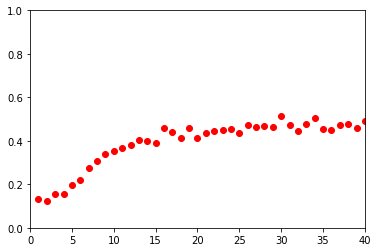

In [7]:
import accuracy_counter as acc
import data_loader
import matplotlib.pyplot as plt


def main():
    x_train, x_test, y_train, y_test = data_loader.hypercubes_loader()

    error_rates = []
    axis = list(range(1, len(x_test) + 1))
    for k in axis:
        error_rates.append(acc.count_accuracy(x_train[k-1], x_test[k-1], y_train[k-1], y_test[k-1]))
    print(error_rates)
    plot(error_rates, axis)


def plot(y, x):
    plt.plot(x, y, 'ro')
    plt.axis([0, len(x), 0, 1])
    plt.show()


if __name__ == '__main__':
    main()


Moduł, który oblicza dla każdego i, średnią z odległości każdego przykładu testowego do najbliższego przykładu treningowego z danej klasy i do przykładu treningowego z klasy przeciwnej, oraz stosunek tych średnich, po czym przedstawia je na wykresie w zależności od i.

In [9]:
import accuracy_counter as acc
import data_loader
import matplotlib.pyplot as plt


def main():
    x_train, x_test, y_train, y_test = data_loader.hypercubes_loader()

    closest_error_rates = []
    contrary_error_rates = []
    axis = list(range(1, len(x_test) + 1))
    for k in axis:
        rates = acc.count_accuracy(x_train[k-1], x_test[k-1], y_train[k-1], y_test[k-1], contrary=True)
        closest_error_rates.append(rates[0])
        contrary_error_rates.append(rates[1])
    print(closest_error_rates)
    print(contrary_error_rates)
    plot(closest_error_rates, contrary_error_rates, max(max(closest_error_rates), max(contrary_error_rates)))


def plot(y1, y2, x):
    plt.plot(x, y1, 'ro')
    plt.plot(x, y2, 'bo')
    plt.axis([0, len(x), 0, 1])
    plt.show()


if __name__ == '__main__':
    main()

[0.00092149000850245359, 0.020339918270793143, 0.069140713478757138, 0.13073598987048665, 0.19984780652067133, 0.26500967412728238, 0.33307687901035399, 0.39347310925695467, 0.46024674558926265, 0.52001604555907466, 0.57917681601393023, 0.63894503859724994, 0.69889185866831383, 0.75061764905630013, 0.80792826697999398, 0.84948312130828807, 0.90844901299116099, 0.95254844714997278, 0.99711528715714726, 1.0462305473516154, 1.0913959822366295, 1.1338264481394966, 1.1826229882631287, 1.2201498147147649, 1.2564618170817747, 1.301639629727519, 1.3400915333213481, 1.3854617939518419, 1.4208867042298963, 1.4636003427241537, 1.5016222014480525, 1.5354746119836076, 1.5703056619996842, 1.608636976933238, 1.642495753192533, 1.6797125291187727, 1.7084004622267668, 1.7421913006087733, 1.7821558876035863, 1.8180681572603328]
[1.2608401976653365, 1.4279217167281302, 1.4994608381179284, 1.5712185311063924, 1.6879061910296782, 1.7210414939997862, 1.783126571993501, 1.8553104002662471, 1.9204829334099422

ValueError: x and y must have same first dimension, but have shapes (1,) and (40,)